In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from publish import *
from scipy import stats

# MEAT DATA TRAJECTORY PER CAPITA
#### External dataset source: https://fred.stlouisfed.org/series/POPTHM

In [9]:
production = pd.read_csv("Datathon Data/Meat_Stats_Meat_Production.csv")
population = pd.read_csv("Datathon Data/external/POPTHM.csv")

In [10]:
production

,Date,Year,Month,Unit,Production,Animal,Commercial or Federally Inspected,Type of Meat
0,Dec-2023,2023,12,Million Pounds,"2,189.80",Beef,Commercial,Red Meat
1,Nov-2023,2023,11,Million Pounds,"2,280.90",Beef,Commercial,Red Meat
2,Oct-2023,2023,10,Million Pounds,"2,340.90",Beef,Commercial,Red Meat
3,Sep-2023,2023,9,Million Pounds,"2,149.40",Beef,Commercial,Red Meat
4,Aug-2023,2023,8,Million Pounds,"2,363.50",Beef,Commercial,Red Meat
...,...,...,...,...,...,...,...,...
13590,May-1921,1921,5,Million Pounds,NaN,Turkey,Federally Inspected,Poultry
13591,Apr-1921,1921,4,Million Pounds,NaN,Turkey,Federally Inspected,Poultry
13592,Mar-1921,1921,3,Million Pounds,NaN,Turkey,Federally Inspected,Poultry
13593,Feb-1921,1921,2,Million Pounds,NaN,Turkey,Federally Inspected,Poultry


In [11]:
POPN_UNIT = 1000 # Units in thousands, as per documentation

population

,DATE,POPTHM
0,1959-01-01,175818.0
1,1959-02-01,176044.0
2,1959-03-01,176274.0
3,1959-04-01,176503.0
4,1959-05-01,176723.0
...,...,...
777,2023-10-01,335773.0
778,2023-11-01,335925.0
779,2023-12-01,336070.0
780,2024-01-01,336194.0


In [12]:
for i, row in population.iterrows():
    if pd.isnull(row["DATE"]):
        print(i, "Date")
    elif pd.isnull(row["POPTHM"]):
        print(i, "POPN")
# We have no NA values

In [13]:
# Adding a time column to population dataset as well
population["Time"] = population["DATE"].apply(lambda x: int(x.split("-")[0]) + (int(x.split("-")[1]) - 1) / 12)
population = population.drop("DATE", axis=1)

population

,POPTHM,Time
0,175818.0,1959.000000
1,176044.0,1959.083333
2,176274.0,1959.166667
3,176503.0,1959.250000
4,176723.0,1959.333333
...,...,...
777,335773.0,2023.750000
778,335925.0,2023.833333
779,336070.0,2023.916667
780,336194.0,2024.000000


In [14]:
# Formatting the production dataset, as in MeatDataScraping.ipynb
production["Production"] = production["Production"].apply(lambda x: x if type(x) == float else float(x.replace(",", "")))
production["Time"] = production["Year"] + (production["Month"] - 1) / 12

In [15]:
for unit in production["Unit"].values:
    if unit != "Million Pounds":
        print("INCONSISTENT UNITS")

In [16]:
PRODUCTION_PER_CAPITA_UNIT = "Pounds per Person" 
# We will format our data so that we have a column of pounds per person

In [17]:
# Furthermore, as animals is a subset of red meat/poultry, we can drop that column and define these categories as sets
RED_MEATS = set()
POULTRY = set()

for _, row in production[["Animal", "Type of Meat"]].iterrows():
    if row["Type of Meat"] == "Red Meat":
        RED_MEATS.add(row["Animal"])
    else:
        POULTRY.add(row["Animal"])

RED_MEATS, POULTRY

({'Beef', 'Lamb and Mutton', 'Pork', 'Veal'},
 {'Broilers', 'Other Chicken', 'Turkey'})

In [18]:
production = production.drop(["Date", "Year", "Month", "Unit", "Type of Meat"], axis=1)

production

,Production,Animal,Commercial or Federally Inspected,Time
0,2189.8,Beef,Commercial,2023.916667
1,2280.9,Beef,Commercial,2023.833333
2,2340.9,Beef,Commercial,2023.750000
3,2149.4,Beef,Commercial,2023.666667
4,2363.5,Beef,Commercial,2023.583333
...,...,...,...,...
13590,NaN,Turkey,Federally Inspected,1921.333333
13591,NaN,Turkey,Federally Inspected,1921.250000
13592,NaN,Turkey,Federally Inspected,1921.166667
13593,NaN,Turkey,Federally Inspected,1921.083333


In [19]:
# Then, partitioning as before
meats = production["Animal"].unique()
production_type = production["Commercial or Federally Inspected"].unique()

meats, production_type

(array(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
        'Other Chicken', 'Turkey'], dtype=object),
 array(['Commercial', 'Federally Inspected'], dtype=object))

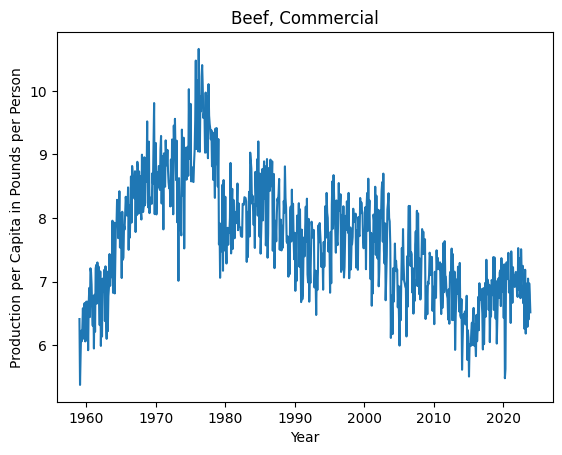

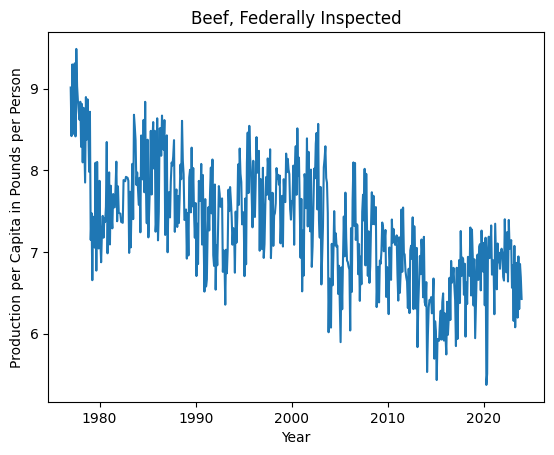

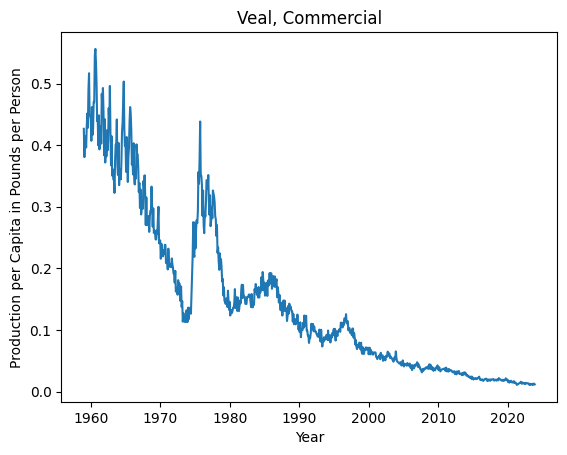

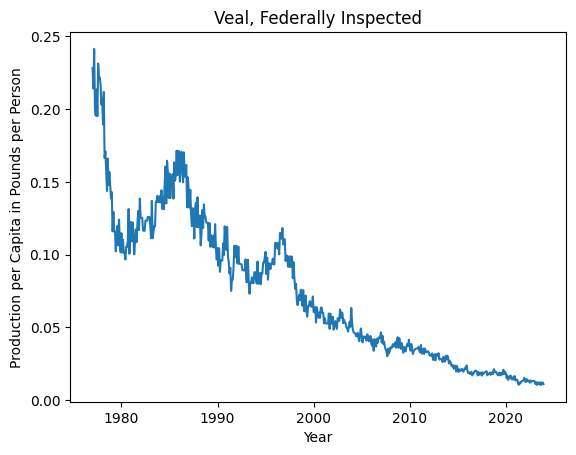

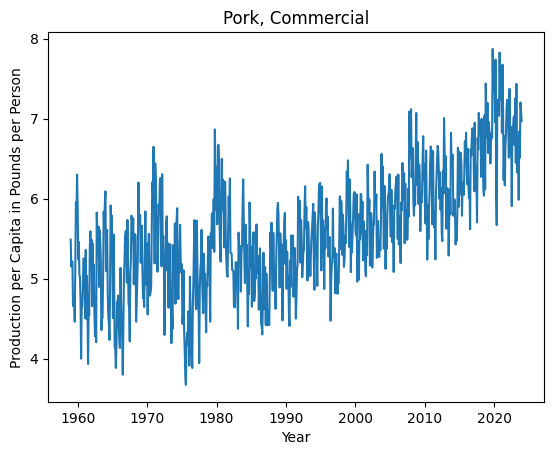

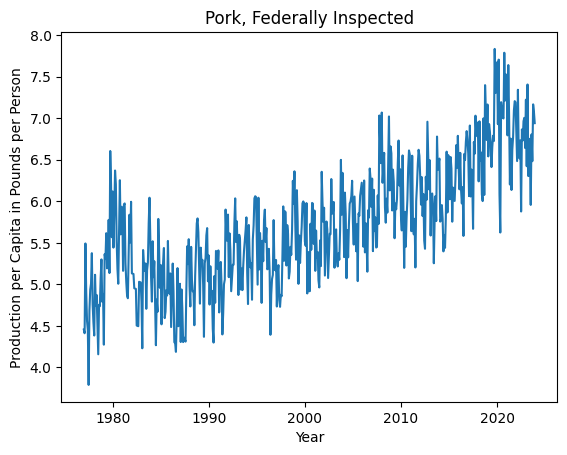

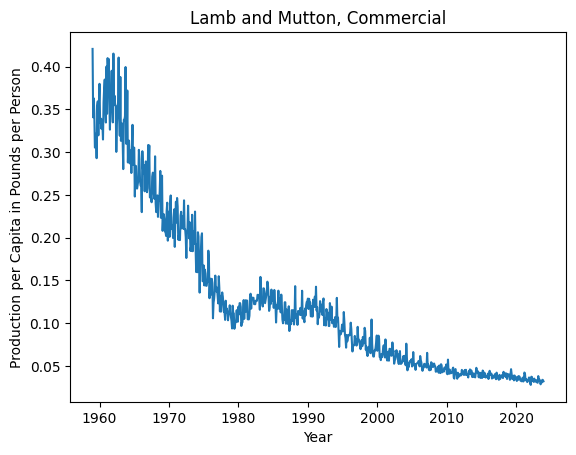

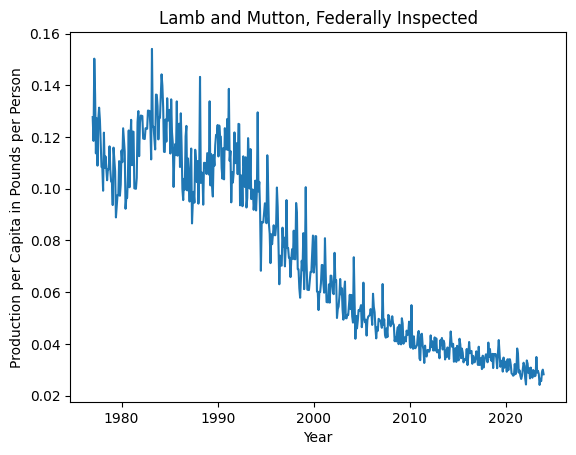

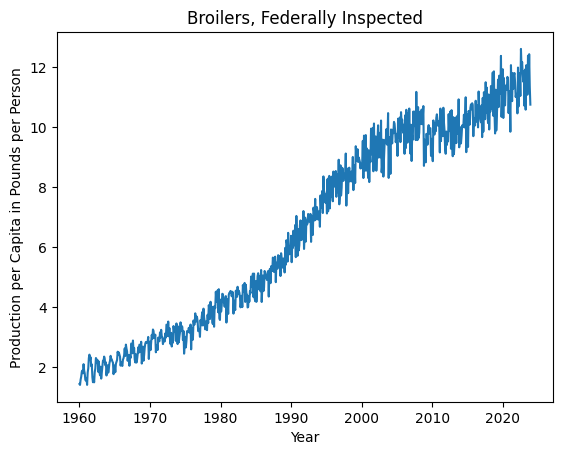

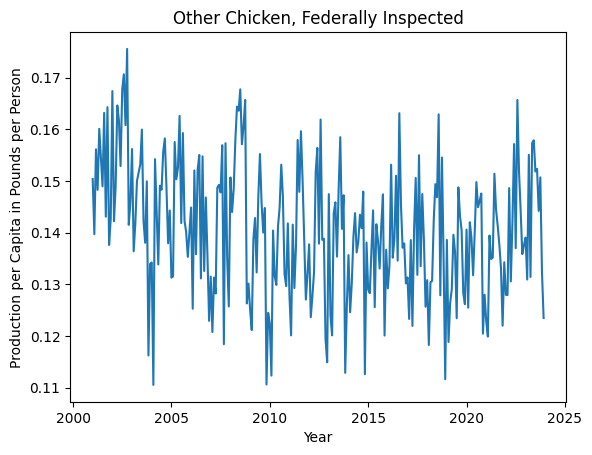

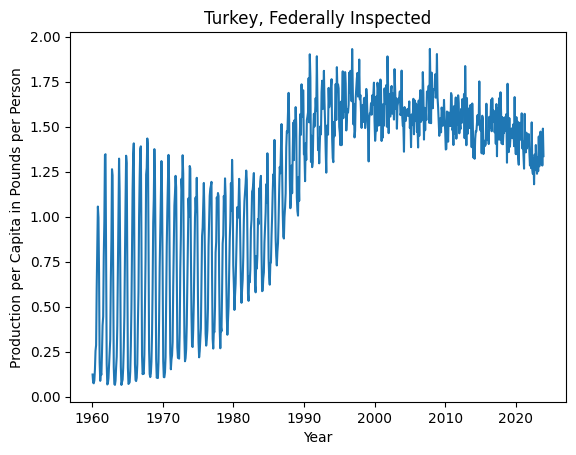

In [20]:
production_dfs = {}

for meat in meats:
    for prod in production_type:
        temp_df = production[(production["Animal"] == meat) & (production["Commercial or Federally Inspected"] == prod)].reset_index().drop(["index"], axis=1)

        max_time_value = min(temp_df["Time"].max(), population["Time"].max())
        min_time_value = max(temp_df["Time"].min(), population["Time"].min())

        temp_df = temp_df[(temp_df["Time"] <= max_time_value) & (temp_df["Time"] >= min_time_value)].reset_index().drop(["index"], axis=1)

        if len(temp_df) == 0:
            continue

        # This code block explained in MeatDataScraping.ipynb
        for i in range(1, len(temp_df) - 1):
            if temp_df.at[i, "Production"] > 2 * temp_df.at[i - 1, "Production"]:
                if pd.isnull(temp_df.at[i + 1, "Production"]) and pd.isnull(temp_df.at[i + 2, "Production"]):
                    temp_df.at[i + 2, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i + 1, "Production"] = temp_df.at[i, "Production"] / 3
                    temp_df.at[i, "Production"] /=3

        # Now, formatting on a per capita basis
        temp_df.loc[:, "Production per Capita"] = (temp_df["Production"].values * 1e6) / (np.flip(population[(population["Time"] <= max_time_value) & (population["Time"] >= min_time_value)]["POPTHM"].values) * POPN_UNIT)

        # This information is held in the name of the dataframe
        temp_df = temp_df.drop(["Animal", "Commercial or Federally Inspected", "Production"], axis=1)

        production_dfs[f"{meat}, {prod}"] = temp_df


        plt.gcf()
        plt.plot(temp_df["Time"].values, temp_df["Production per Capita"].values)
        plt.title(f"{meat}, {prod}")
        plt.xlabel("Year")
        plt.ylabel(f"Production per Capita in {PRODUCTION_PER_CAPITA_UNIT}")
        plt.show()

## Linear Regression Analysis

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
# Arbitrary values, more to follow after Arav's analysis
START_TIME = 2001 # MUST BE BIGGER THAN 2001, to avoid dealing with NA values
VEGAN_START_TIME = 2017

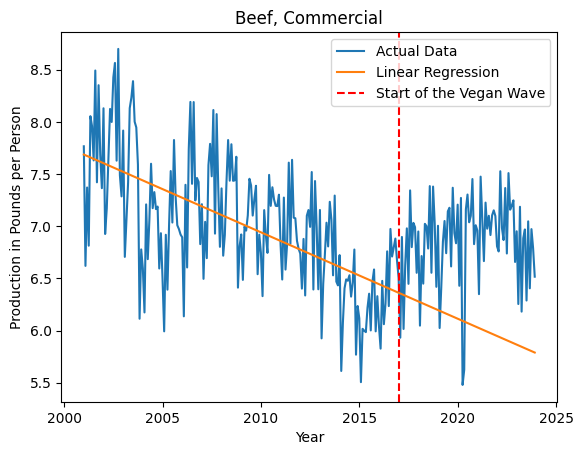

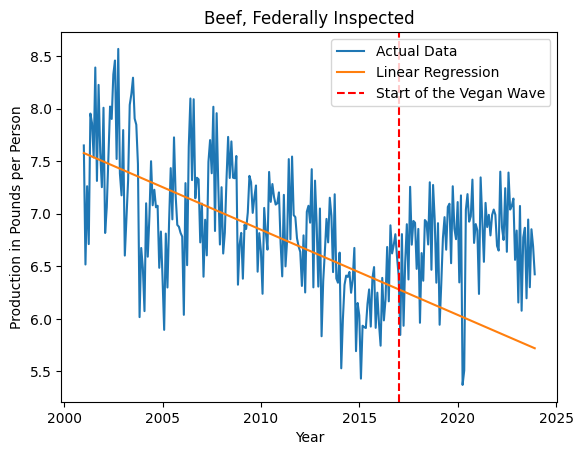

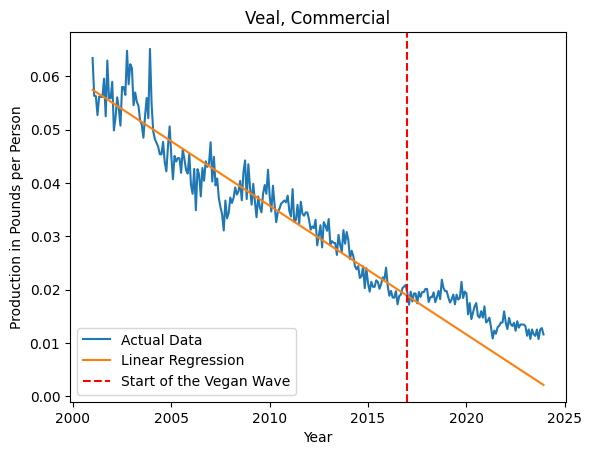

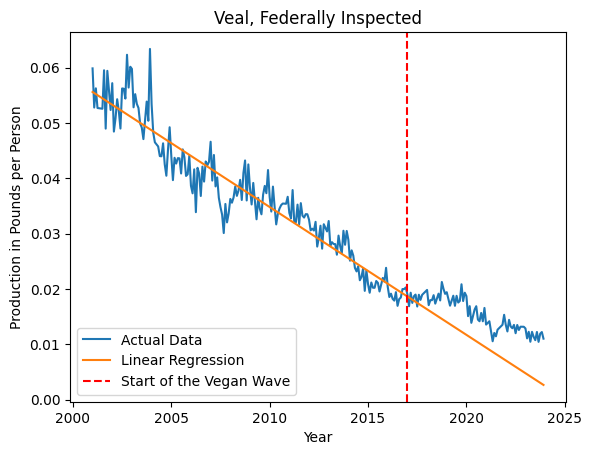

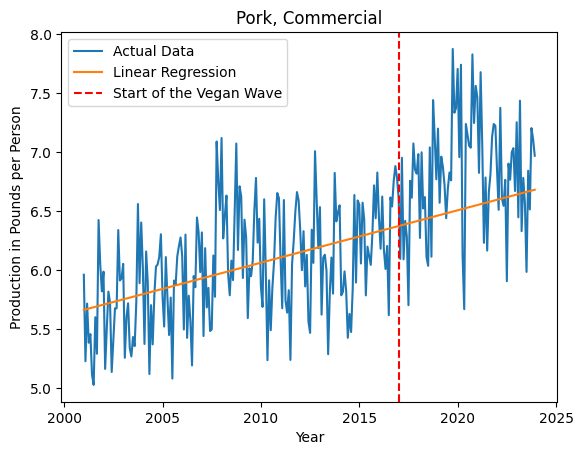

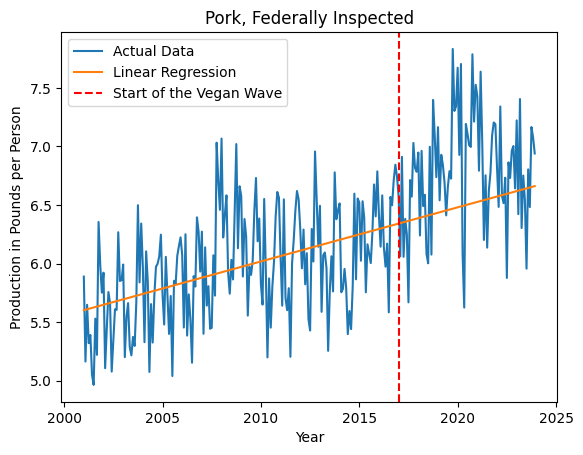

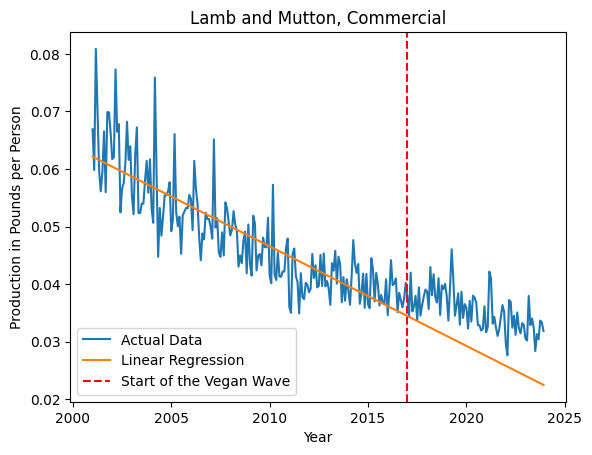

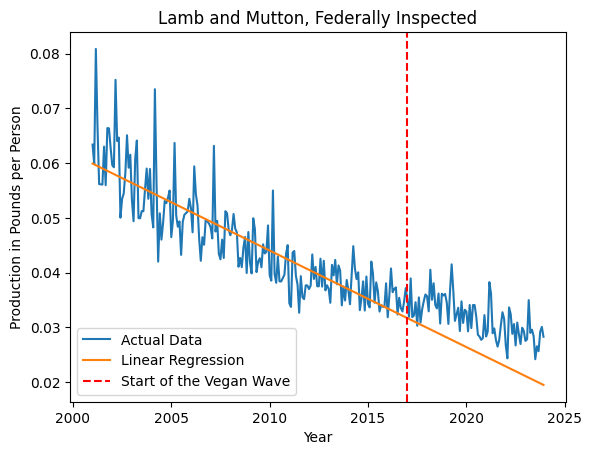

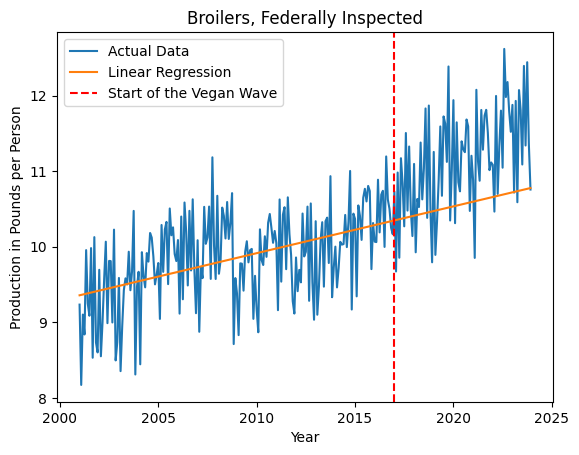

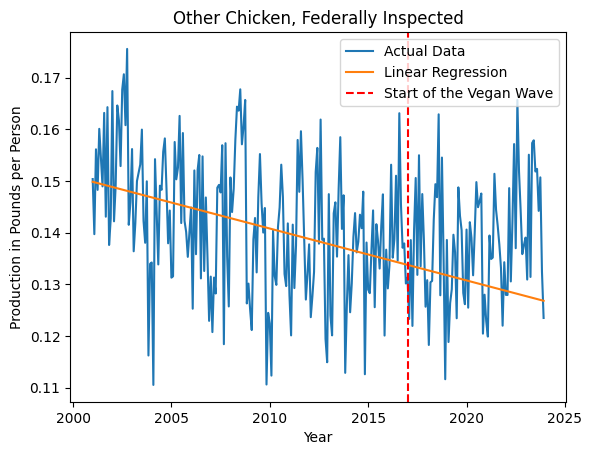

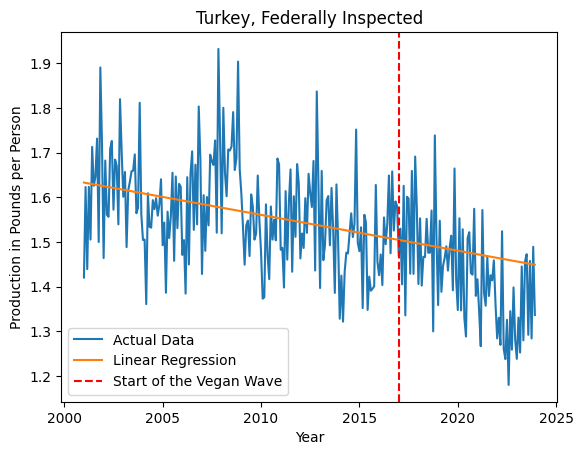

In [25]:
for label in production_dfs:
    xs = production_dfs[label][(production_dfs[label]["Time"] <= VEGAN_START_TIME) & (production_dfs[label]["Time"] >= START_TIME)]["Time"].values.reshape(-1, 1)
    ys = production_dfs[label][(production_dfs[label]["Time"] <= VEGAN_START_TIME) & (production_dfs[label]["Time"] >= START_TIME)]["Production per Capita"].values

    if any(pd.isnull(ys)): # This won't be needed if START TIME >= 2001
        continue

    linear_model = LinearRegression()
    linear_model.fit(xs, ys)

    gradient = linear_model.coef_
    intercept = linear_model.intercept_

    plot_xs = production_dfs[label][(production_dfs[label]["Time"] >= START_TIME)]["Time"].values
    plot_ys = production_dfs[label][(production_dfs[label]["Time"] >= START_TIME)]["Production per Capita"].values

    plt.gcf()
    plt.plot(plot_xs, plot_ys, label="Actual Data")
    plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
    plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
    plt.title(label)
    plt.xlabel("Year")
    plt.ylabel(f"Production in {PRODUCTION_PER_CAPITA_UNIT}")
    plt.legend()
    plt.show()

#### Results from individual categories seem insignificant

In [26]:
production_dfs_animal = {}

for label in production_dfs:
    animal, _ = label.split(",")

    if animal not in production_dfs_animal:
        production_dfs_animal[animal] = production_dfs[label][production_dfs[label]["Time"] >= START_TIME]
    else:
        production_dfs_animal[animal].loc[:, "Production per Capita"] = production_dfs_animal[animal]["Production per Capita"].values + production_dfs[label][production_dfs[label]["Time"] >= START_TIME]["Production per Capita"].values 

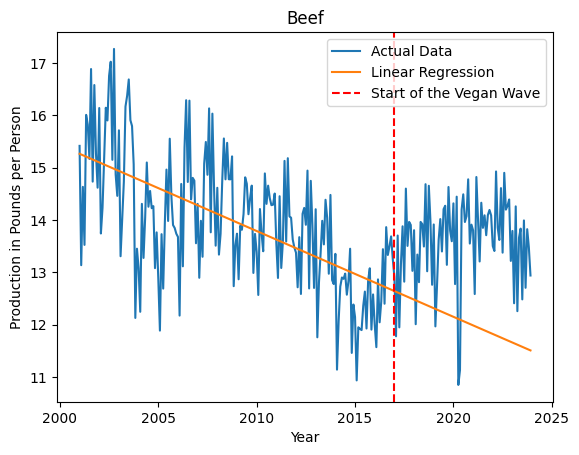

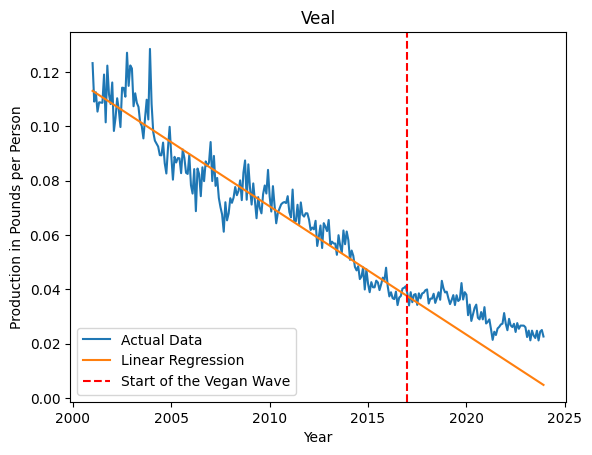

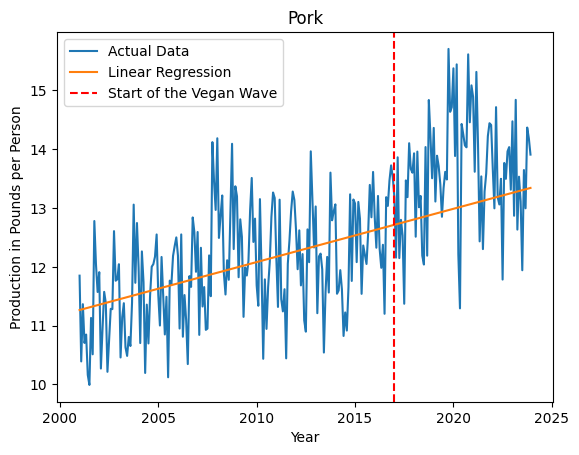

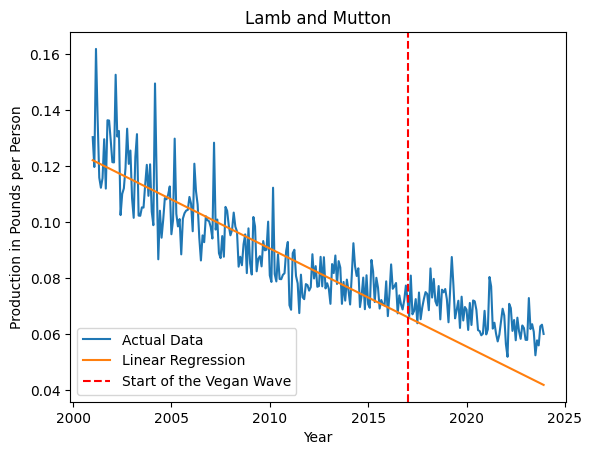

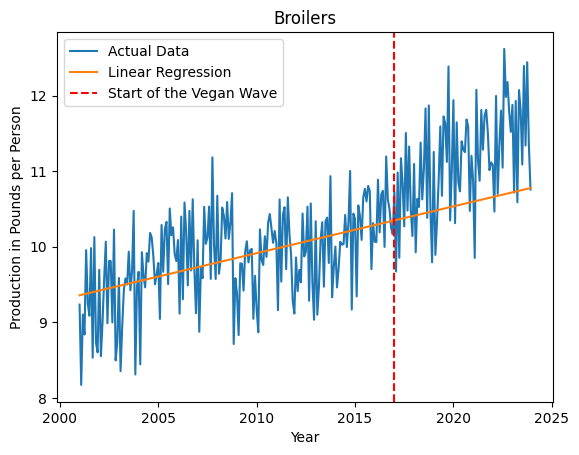

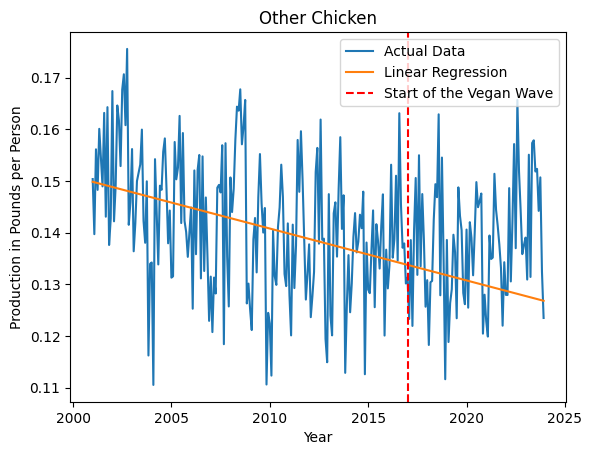

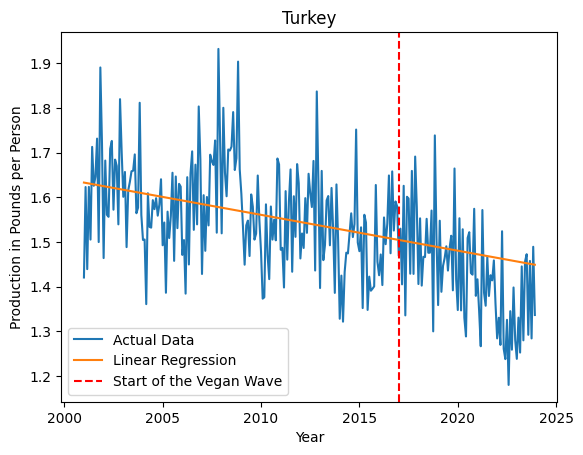

In [27]:
for label in production_dfs_animal:
    xs = production_dfs_animal[label][(production_dfs_animal[label]["Time"] <= VEGAN_START_TIME) & (production_dfs_animal[label]["Time"] >= START_TIME)]["Time"].values.reshape(-1, 1)
    ys = production_dfs_animal[label][(production_dfs_animal[label]["Time"] <= VEGAN_START_TIME) & (production_dfs_animal[label]["Time"] >= START_TIME)]["Production per Capita"].values

    if any(pd.isnull(ys)): # This won't be needed if START TIME >= 2001
        continue

    linear_model = LinearRegression()
    linear_model.fit(xs, ys)

    gradient = linear_model.coef_
    intercept = linear_model.intercept_

    plot_xs = production_dfs_animal[label][(production_dfs_animal[label]["Time"] >= START_TIME)]["Time"].values
    plot_ys = production_dfs_animal[label][(production_dfs_animal[label]["Time"] >= START_TIME)]["Production per Capita"].values

    plt.gcf()
    plt.plot(plot_xs, plot_ys, label="Actual Data")
    plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
    plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
    plt.title(label)
    plt.xlabel("Year")
    plt.ylabel(f"Production in {PRODUCTION_PER_CAPITA_UNIT}")
    plt.legend()
    plt.show()

#### Seems insignificant, bar Turkey and Beef

In [28]:
total_df = []

for animal in production_dfs_animal:
    if len(total_df) == 0:
        total_df = production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START_TIME]
    else:
        total_df.loc[:, "Production per Capita"] = total_df["Production per Capita"].values + production_dfs_animal[animal][production_dfs_animal[animal]["Time"] >= START_TIME]["Production per Capita"].values

total_df

,Time,Production per Capita
0,2023.916667,39.148392
1,2023.833333,40.740046
2,2023.750000,42.155861
3,2023.666667,38.719414
4,2023.583333,41.556684
...,...,...
271,2001.333333,38.699734
272,2001.250000,35.083731
273,2001.166667,36.969196
274,2001.083333,33.691927


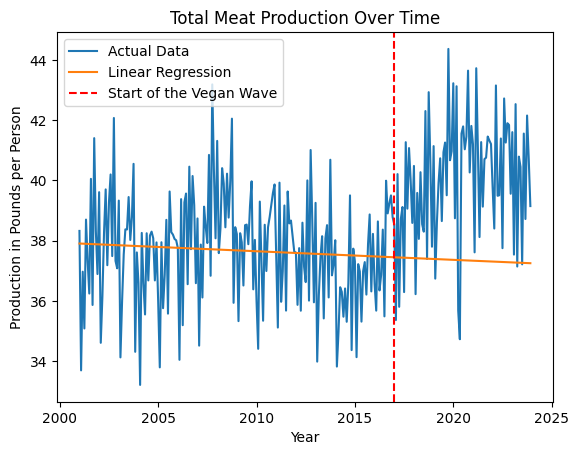

In [29]:
xs = total_df[total_df["Time"] <= VEGAN_START_TIME]["Time"].values.reshape(-1, 1)
ys = total_df[total_df["Time"] <= VEGAN_START_TIME]["Production per Capita"].values

linear_model = LinearRegression()
linear_model.fit(xs, ys)

gradient = linear_model.coef_
intercept = linear_model.intercept_

plot_xs = total_df["Time"].values
plot_ys = total_df["Production per Capita"].values

plt.gcf()
plt.plot(plot_xs, plot_ys, label="Actual Data")
plt.plot(plot_xs, gradient * plot_xs + intercept, label="Linear Regression")
plt.axvline(VEGAN_START_TIME, color='red', linestyle="--", label="Start of the Vegan Wave")
plt.title("Total Meat Production Over Time")
plt.xlabel("Year")
plt.ylabel(f"Production in {PRODUCTION_PER_CAPITA_UNIT}")
plt.legend()
plt.show()

#### per capita production has roughly 0 slope. but does this mean we can consider raw values instead of differences? if so, use this; otherwise use below

In [33]:
pre_vegan_totals = total_df[total_df["Time"] < VEGAN_START_TIME]["Production per Capita"].values
post_vegan_totals = total_df[total_df["Time"] >= VEGAN_START_TIME]["Production per Capita"].values

pre_vegan_totals, post_vegan_totals

(array([38.78161244, 39.50276752, 39.23956873, 38.9054451 , 39.99089018,
        35.48569897, 38.36678213, 36.86794548, 36.34716921, 38.63853201,
        35.67644051, 36.57827139, 38.2252148 , 36.3148496 , 38.87042778,
        37.88328633, 36.20912641, 37.28777787, 36.98447604, 35.31080997,
        36.97478992, 37.21961512, 34.13084904, 37.31592507, 37.73451989,
        34.36509719, 39.50337544, 36.58945672, 35.30612436, 36.4119248 ,
        35.47448957, 36.297909  , 36.45414081, 34.97696243, 33.8182035 ,
        38.01465786, 37.21047141, 36.84811177, 40.68721214, 36.11409322,
        38.51548691, 38.07432305, 35.4171531 , 38.1480698 , 37.45430995,
        36.18854648, 33.98294069, 39.255406  , 35.95228522, 38.64747919,
        41.0108246 , 36.00886876, 40.00114274, 36.62308289, 37.13474645,
        38.59648565, 35.67363516, 37.75179701, 35.8680862 , 37.60537693,
        37.63486827, 38.134457  , 38.66766754, 38.5728259 , 39.63308328,
        35.67733344, 39.16776391, 36.99296328, 35.9

In [34]:
np.var(pre_vegan_totals), np.var(post_vegan_totals)

(3.3167028301066632, 4.265460557196185)

In [36]:
stats.ttest_ind(pre_vegan_totals, post_vegan_totals, equal_var=True)

Ttest_indResult(statistic=-9.386515763380286, pvalue=2.4890895306145784e-18)

In [37]:
pre_vegan_diffs = np.diff(pre_vegan_totals)
post_vegan_diffs = np.diff(post_vegan_totals)

pre_vegan_diffs, post_vegan_diffs

(array([ 7.21155080e-01, -2.63198788e-01, -3.34123639e-01,  1.08544508e+00,
        -4.50519120e+00,  2.88108316e+00, -1.49883666e+00, -5.20776270e-01,
         2.29136280e+00, -2.96209150e+00,  9.01830881e-01,  1.64694341e+00,
        -1.91036520e+00,  2.55557817e+00, -9.87141448e-01, -1.67415992e+00,
         1.07865146e+00, -3.03301824e-01, -1.67366607e+00,  1.66397995e+00,
         2.44825201e-01, -3.08876608e+00,  3.18507603e+00,  4.18594824e-01,
        -3.36942271e+00,  5.13827825e+00, -2.91391872e+00, -1.28333236e+00,
         1.10580043e+00, -9.37435225e-01,  8.23419426e-01,  1.56231808e-01,
        -1.47717838e+00, -1.15875893e+00,  4.19645436e+00, -8.04186443e-01,
        -3.62359643e-01,  3.83910037e+00, -4.57311892e+00,  2.40139369e+00,
        -4.41163868e-01, -2.65716995e+00,  2.73091670e+00, -6.93759851e-01,
        -1.26576347e+00, -2.20560579e+00,  5.27246530e+00, -3.30312077e+00,
         2.69519396e+00,  2.36334541e+00, -5.00195585e+00,  3.99227399e+00,
        -3.3

In [38]:
np.var(pre_vegan_diffs), np.var(post_vegan_diffs)

(6.870723807626353, 9.670373714429935)

In [39]:
stats.ttest_ind(pre_vegan_diffs, post_vegan_diffs, equal_var = True)

Ttest_indResult(statistic=0.01341236301980025, pvalue=0.9893086357620853)